In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [6]:
data = pd.read_csv("final_10minutes.csv")
data.drop(['Month'], axis =1, inplace= True)
#data.set_index("time", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['Unnamed: 0',  'green', 'yellow', 'total'], axis =1, inplace = True)

In [7]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [8]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [9]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3*6:, -1])
n_p = n_p + 365*24*3*6

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [10]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 6
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(157680, 235) 157680 (157680,)
(157680, 47, 5) (157680,) (39361, 47, 5) (39361,)


Density = 2

In [11]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(24))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 157680 samples, validate on 39361 samples
Epoch 1/100
 - 126s - loss: 0.0331 - val_loss: 0.0130
Epoch 2/100
 - 125s - loss: 0.0162 - val_loss: 0.0105
Epoch 3/100
 - 124s - loss: 0.0135 - val_loss: 0.0091
Epoch 4/100
 - 125s - loss: 0.0126 - val_loss: 0.0100
Epoch 5/100
 - 124s - loss: 0.0118 - val_loss: 0.0091
Epoch 6/100
 - 124s - loss: 0.0117 - val_loss: 0.0096
Epoch 7/100
 - 125s - loss: 0.0111 - val_loss: 0.0089
Epoch 8/100
 - 124s - loss: 0.0110 - val_loss: 0.0090
Epoch 9/100
 - 125s - loss: 0.0108 - val_loss: 0.0090
Epoch 10/100
 - 124s - loss: 0.0106 - val_loss: 0.0091
Epoch 11/100
 - 125s - loss: 0.0104 - val_loss: 0.0088
Epoch 12/100
 - 124s - loss: 0.0103 - val_loss: 0.0087
Epoch 13/100
 - 124s - loss: 0.0101 - val_loss: 0.0086
Epoch 14/100
 - 125s - loss: 0.0098 - val_loss: 0.0087
Epoch 15/100
 - 124s - loss: 0.0097 - val_loss: 0.0084
Epoch 16/100
 - 124s - loss: 0.0095 - val_loss: 0.0085
Epoch 17/100
 - 125s - loss: 0.0092 - val_loss: 0.0083
Epoch 18/100
 - 125s - 

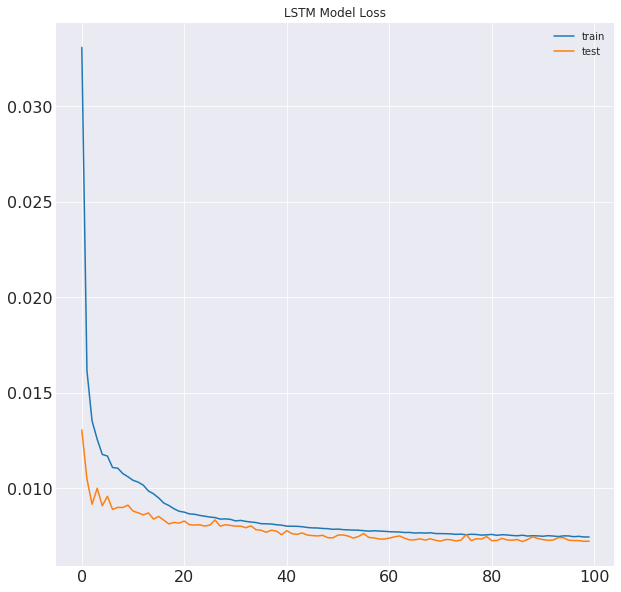

In [12]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [13]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.992280002378746
MAE:  69.289154
RMSE: 97.57025213435958
mean absolute error percentage:  3.6118358373641968


In [14]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9907140345430047
MAE:  99.49035
RMSE: 138.29339988996222
mean absolute error percentage:  3.660140186548233


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


Density = 3

In [15]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 6
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(157680, 235) 157680 (157680,)
(157680, 47, 5) (157680,) (39361, 47, 5) (39361,)


In [16]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(24, return_sequences=True))
model.add(LSTM(24))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 157680 samples, validate on 39361 samples
Epoch 1/100
 - 126s - loss: 0.0349 - val_loss: 0.0141
Epoch 2/100
 - 124s - loss: 0.0173 - val_loss: 0.0126
Epoch 3/100
 - 124s - loss: 0.0142 - val_loss: 0.0098
Epoch 4/100
 - 125s - loss: 0.0127 - val_loss: 0.0098
Epoch 5/100
 - 124s - loss: 0.0122 - val_loss: 0.0092
Epoch 6/100
 - 125s - loss: 0.0116 - val_loss: 0.0094
Epoch 7/100
 - 124s - loss: 0.0112 - val_loss: 0.0097
Epoch 8/100
 - 125s - loss: 0.0110 - val_loss: 0.0089
Epoch 9/100
 - 125s - loss: 0.0110 - val_loss: 0.0092
Epoch 10/100
 - 125s - loss: 0.0106 - val_loss: 0.0093
Epoch 11/100
 - 125s - loss: 0.0106 - val_loss: 0.0091
Epoch 12/100
 - 126s - loss: 0.0102 - val_loss: 0.0091
Epoch 13/100
 - 124s - loss: 0.0099 - val_loss: 0.0086
Epoch 14/100
 - 125s - loss: 0.0095 - val_loss: 0.0089
Epoch 15/100
 - 125s - loss: 0.0093 - val_loss: 0.0088
Epoch 16/100
 - 125s - loss: 0.0092 - val_loss: 0.0087
Epoch 17/100
 - 125s - loss: 0.0091 - val_loss: 0.0086
Epoch 18/100
 - 124s - 

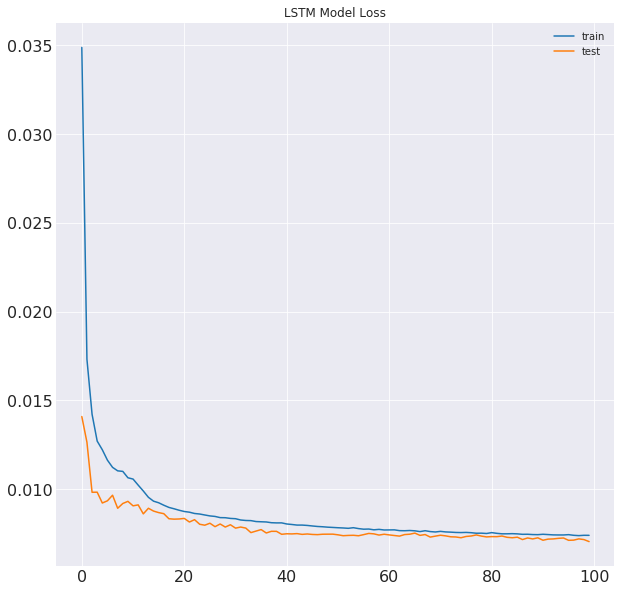

In [17]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [18]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9925557720758111
MAE:  67.771
RMSE: 95.81173046820781
mean absolute error percentage:  3.4877218306064606


In [19]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9903295841127115
MAE:  102.16107
RMSE: 141.09531076102422
mean absolute error percentage:  3.614412620663643


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
